In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [3]:
import mlflow

# database to store mlflow artifacts (same as u enter in the cli)
mlflow.set_tracking_uri("sqlite:///mlflow.db")
# experiment name
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-exp_tracking_and_model_management/mlruns/1', creation_time=1738426403138, experiment_id='1', last_update_time=1738426403138, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [5]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration'],
      dtype='object')

In [6]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.775464552087287

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


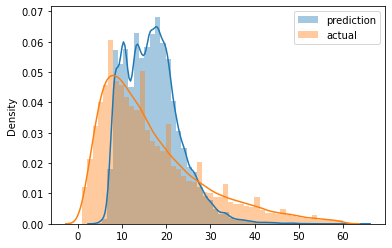

In [7]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [ ]:
df_val.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.0,...,0.5,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.5,...,0.5,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.5,...,0.5,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.0,...,0.5,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.5,...,0.5,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667


In [10]:
len(df_train), len(df_val)

(73908, 61921)

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [12]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.479562160810692

In [14]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### Logging with MLflow

In [15]:
# this is how to track an experiment run in mlflow
with mlflow.start_run():
    mlflow.set_tag("developer", "ganesh")
    mlflow.log_param("train-data-path", './data/green_tripdata_2021-01.parquet')
    mlflow.log_param("valid-data-path", './data/green_tripdata_2021-02.parquet')
    
    alpha = 0.02
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

# all the tags, params and metrics that u set here will be visible in the ui

### Testing multiple params with hyperopt

In [16]:
import xgboost as xgb

# hyperopt is a module that can be use to test out different hyper parameters at once
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [17]:
# this is training and validation data in xgboost DMatrix format
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:
# the objective function is a function what will be optimized by hyperopt based on the passed parameters
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation") ],
            early_stopping_rounds=50
        )

        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}


In [21]:
# The search space defines the ranges of the hyperparameters which we want hyperopt to explore
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

# the fmin function tries to optimise the objective function by minimising its results
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials())

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:52:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.20465                           
[1]	validation-rmse:7.12549                           
[2]	validation-rmse:6.84512                           
[3]	validation-rmse:6.75655                           
[4]	validation-rmse:6.72276                           
[5]	validation-rmse:6.71031                           
[6]	validation-rmse:6.70300                           
[7]	validation-rmse:6.69735                           
[8]	validation-rmse:6.69489                           
[9]	validation-rmse:6.69275                           
[10]	validation-rmse:6.68921                          
[11]	validation-rmse:6.68789                          
[12]	validation-rmse:6.68385                          
[13]	validation-rmse:6.68223                          
[14]	validation-rmse:6.67720                          
[15]	validation-rmse:6.67299                          
[16]	validation-rmse:6.66699                          
[17]	validation-rmse:6.66252                          
[18]	valid

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:53:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.09427                                                   
[1]	validation-rmse:10.17862                                                   
[2]	validation-rmse:9.44310                                                    
[3]	validation-rmse:8.83584                                                    
[4]	validation-rmse:8.36528                                                    
[5]	validation-rmse:7.98777                                                    
[6]	validation-rmse:7.69339                                                    
[7]	validation-rmse:7.45249                                                    
[8]	validation-rmse:7.26785                                                    
[9]	validation-rmse:7.12553                                                    
[10]	validation-rmse:7.01143                                                   
[11]	validation-rmse:6.92121                                                   
[12]	validation-rmse:6.84706            

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:57:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.69290                                                     
[1]	validation-rmse:6.62814                                                     
[2]	validation-rmse:6.61577                                                     
[3]	validation-rmse:6.61096                                                     
[4]	validation-rmse:6.60354                                                     
[5]	validation-rmse:6.59949                                                     
[6]	validation-rmse:6.59333                                                     
[7]	validation-rmse:6.58261                                                     
[8]	validation-rmse:6.57670                                                     
[9]	validation-rmse:6.57229                                                     
[10]	validation-rmse:6.55713                                                    
[11]	validation-rmse:6.55209                                                    
[12]	validation-rmse:6.55006

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:57:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.51896                                                   
[1]	validation-rmse:10.90359                                                   
[2]	validation-rmse:10.35990                                                   
[3]	validation-rmse:9.88052                                                    
[4]	validation-rmse:9.45859                                                    
[5]	validation-rmse:9.08930                                                    
[6]	validation-rmse:8.76689                                                    
[7]	validation-rmse:8.48585                                                    
[8]	validation-rmse:8.24138                                                    
[9]	validation-rmse:8.02965                                                    
[10]	validation-rmse:7.84663                                                   
[11]	validation-rmse:7.68805                                                   
[12]	validation-rmse:7.55153            

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:00:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.31608                                                    
[1]	validation-rmse:9.02161                                                     
[2]	validation-rmse:8.17971                                                     
[3]	validation-rmse:7.59589                                                     
[4]	validation-rmse:7.24149                                                     
[5]	validation-rmse:7.01636                                                     
[6]	validation-rmse:6.85680                                                     
[7]	validation-rmse:6.75563                                                     
[8]	validation-rmse:6.69245                                                     
[9]	validation-rmse:6.64143                                                     
[10]	validation-rmse:6.60939                                                    
[11]	validation-rmse:6.58599                                                    
[12]	validation-rmse:6.56218

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:02:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.61352                                                    
[1]	validation-rmse:9.44381                                                     
[2]	validation-rmse:8.60523                                                     
[3]	validation-rmse:8.00959                                                     
[4]	validation-rmse:7.59880                                                     
[5]	validation-rmse:7.30927                                                     
[6]	validation-rmse:7.10605                                                     
[7]	validation-rmse:6.96927                                                     
[8]	validation-rmse:6.86479                                                     
[9]	validation-rmse:6.79539                                                     
[10]	validation-rmse:6.74216                                                    
[11]	validation-rmse:6.70594                                                    
[12]	validation-rmse:6.67418

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:04:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.29942                                                     
[1]	validation-rmse:6.71664                                                     
[2]	validation-rmse:6.62976                                                     
[3]	validation-rmse:6.61142                                                     
[4]	validation-rmse:6.60235                                                     
[5]	validation-rmse:6.59476                                                     
[6]	validation-rmse:6.58744                                                     
[7]	validation-rmse:6.58098                                                     
[8]	validation-rmse:6.56932                                                     
[9]	validation-rmse:6.56634                                                     
[10]	validation-rmse:6.56162                                                    
[11]	validation-rmse:6.55455                                                    
[12]	validation-rmse:6.54636

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:04:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.08036                                                   
[1]	validation-rmse:10.15997                                                   
[2]	validation-rmse:9.41863                                                    
[3]	validation-rmse:8.82508                                                    
[4]	validation-rmse:8.35533                                                    
[5]	validation-rmse:7.98584                                                    
[6]	validation-rmse:7.69639                                                    
[7]	validation-rmse:7.47044                                                    
[8]	validation-rmse:7.29383                                                    
[9]	validation-rmse:7.15601                                                    
[10]	validation-rmse:7.04940                                                   
[11]	validation-rmse:6.96637                                                   
[12]	validation-rmse:6.89732            

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:08:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.06310                                                     
[1]	validation-rmse:6.68298                                                     
[2]	validation-rmse:6.63287                                                     
[3]	validation-rmse:6.61837                                                     
[4]	validation-rmse:6.61216                                                     
[5]	validation-rmse:6.60411                                                     
[6]	validation-rmse:6.59979                                                     
[7]	validation-rmse:6.59414                                                     
[8]	validation-rmse:6.58889                                                     
[9]	validation-rmse:6.58282                                                     
[10]	validation-rmse:6.57713                                                    
[11]	validation-rmse:6.57253                                                    
[12]	validation-rmse:6.56867

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:08:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.31852                                                    
[1]	validation-rmse:6.79463                                                    
[2]	validation-rmse:6.71774                                                    
[3]	validation-rmse:6.69727                                                    
[4]	validation-rmse:6.68948                                                    
[5]	validation-rmse:6.68319                                                    
[6]	validation-rmse:6.67821                                                    
[7]	validation-rmse:6.66777                                                    
[8]	validation-rmse:6.66272                                                    
[9]	validation-rmse:6.65753                                                    
[10]	validation-rmse:6.65435                                                   
[11]	validation-rmse:6.65113                                                   
[12]	validation-rmse:6.65006            

### MLflow autologging
With certain libraries, MLflow supports logging of informations automatically.  
Lets try that with xgboost.

In [ ]:
# picking up the params from the best model from the previous runs

params = {
    "learning_rate": 0.5763236052343594,
    "max_depth": 9,
    "min_child_weight": 1.1776509046963355,
    "objective": "reg:linear",
    "reg_alpha": 0.1580754051451351,
    "reg_lambda": 0.0229211019575323,
    "seed": 42
}

# this will enable autologging with xgboost library
# u wont have to write things like mlflow.start_run(), mlflow.set_tag(), etc
mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation") ],
            early_stopping_rounds=50
        )

# killed the kernel in codespaces. try again later